In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import seaborn
import matplotlib.pyplot as plt
import os
import emcee

In [ ]:
import numpy as np
import pickle

cosmos_f = open('cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

box = 'Box0_1400'
h = cosmo_params[box]['H0']/100

Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_Pk.pkl'
Pk_f = open(Pk_fname, 'rb')
Pkz = pickle.load(Pk_f) #Pkz is a dictonary of functions
Pk_f.close()

dndM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_dndM.pkl'
dndM_f = open(dndM_fname, 'rb')
dndMs = pickle.load(dndM_f) #dndMs is a dictionary of dictionaries
dndM_f.close()

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

In [6]:
#slight floating point error fix
#needed since I set the dictionary 
#equal to the redshift or scale
z_to_a = dict(zip(Pkz.keys(), dndMs.keys()))
a_to_z = dict(zip(dndMs.keys(), Pkz.keys()))

0



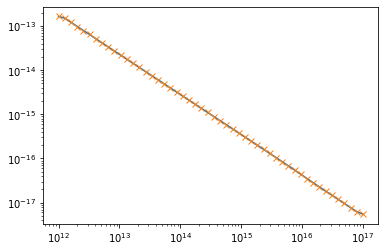

23



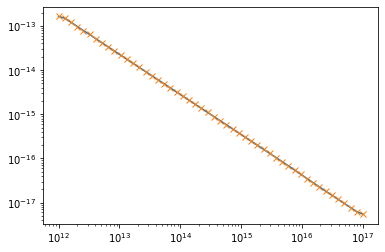

50



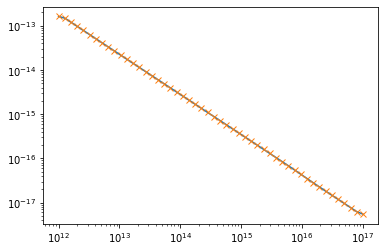

78



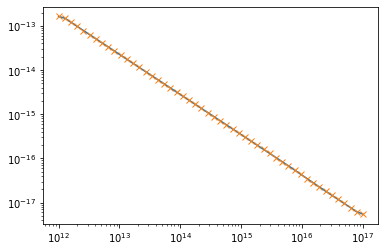

106



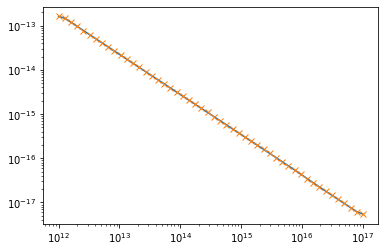

134



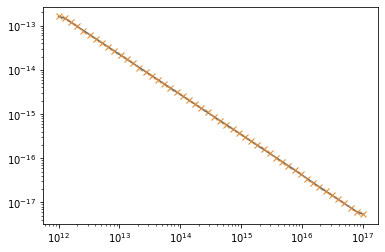

162



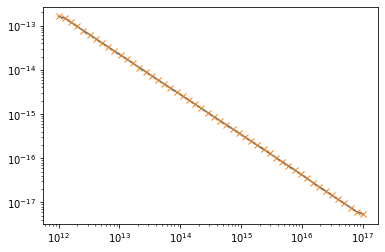

190



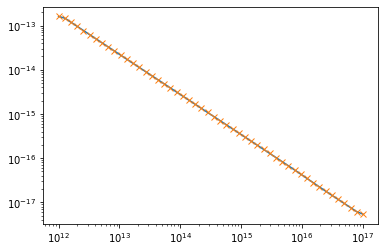

218



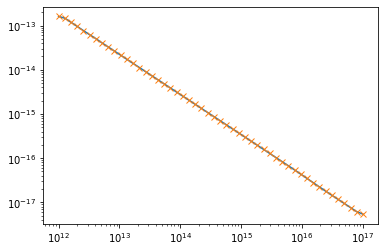

246



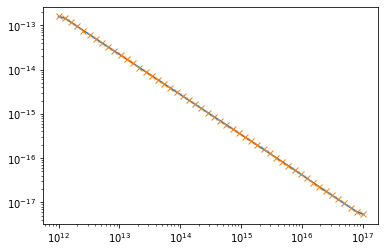

273



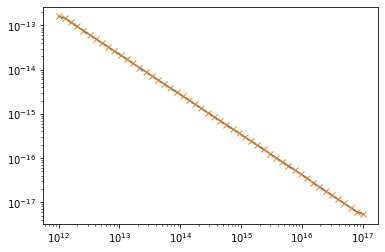

300



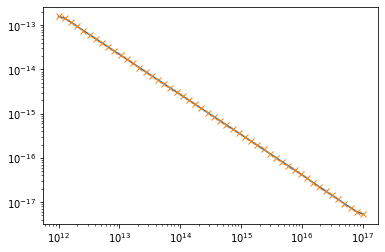

328



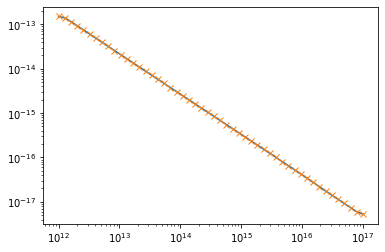

355



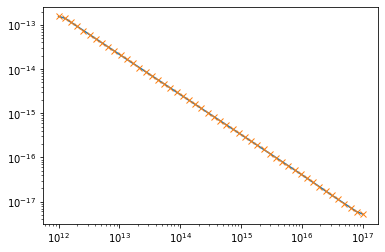

383



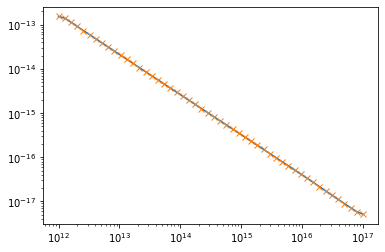

411



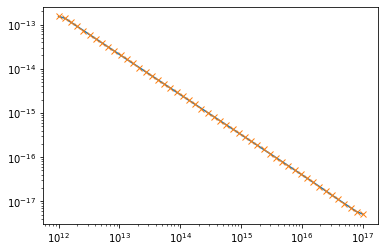

In [32]:
#give cosmology, a, M => output

data = []
N_data = []
from scipy.interpolate import interp1d

dlnσinvdMs = {}
dlnσinvdlogMs = {}
for (z, a) in zip(Pkz.keys(), dndMs.keys()):
    print(len(data))
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M']
    N = c_data['N']
    
    vol = c_data['vol']
    
    Ngt10 = np.where(N>10)
    edges = c_data['bin_edges']
    dlog10M = np.mean(np.diff(np.log10(edges)))
    edge_pairs = np.array([[edges[i], edges[i+1]] for i in range(len(edges)-1)])
    edge_pairs = edge_pairs[Ngt10]
    assert(len(edge_pairs) == len(Ms))
    assert(len(N) == len(Ms))
#     dMs = c_data[ 'dM']
    
    datapoint = {}
    for N_cur, M_cur, edge_pair in zip(N,Ms, edge_pairs ):
        datapoint['a'] = a
        datapoint['M'] = M_cur
        datapoint['N'] = N_cur
        N_data += [N_cur]
        datapoint['dlog10M'] = dlog10M
        datapoint['edges'] = edge_pair
        datapoint['vol'] = vol
        data += [datapoint]
    
    sM = np.logspace(12, 17, 50)
    print()
    R = [M_to_R(m, box, a) for m in sM]
    sigma = [np.sqrt(sigma2(Pk, r)) for r in R]
    lnsigmainv = -np.log(sigma)

#     dsinvdM = np.gradient(sigmainv, sM)
    dlnsinvdM = np.gradient(lnsigmainv, sM)
    dlnsinvdlogM = np.gradient(lnsigmainv, np.mean(np.diff(np.log10(sM))))

    
    f_dlnsinvdM_log = interp1d(np.log10(sM), dlnsinvdM,kind='cubic')
    f_dlnsinvdM = lambda x: f_dlnsinvdM_log(np.log10(x))

    f_dlnsinvdlogM = interp1d(sM, dlnsinvdlogM,kind='cubic')

    dlnσinvdMs[a] = f_dlnsinvdM
    dlnσinvdlogMs[a] = f_dlnsinvdlogM
    
    f_M = np.logspace(np.log10(np.min(Ms)), np.log10(np.max(Ms)-1),100)
#     plt.scatter(sM, dlnsinvdlogM)
#     plt.plot(sM, f_dlnsinvdlogM(sM))
#     plt.plot(sM, f_dlnsinvdM(sM)*np.log(10)*sM)
    plt.plot(sM, f_dlnsinvdM(sM))
    plt.plot(sM, dlnsinvdM, 'x')

    plt.xscale('log')
    plt.yscale('log')
    plt.show()


In [33]:
from scipy.special import gamma
from scipy.optimize import curve_fit



def p(a, p0, p1):
    oup = (p0)+(a-0.5)*(p1)
    return oup

def B(a, M, σM, d, e, f, g):
    oup = e**(d)*g**(-d/2)*gamma(d/2)
    oup += g**(-f/2)*gamma(f/2)
    oup = 2/oup
    return oup
    
    
def f_G(a, M, σM, d, e, f, g):
    oup = B(a, M, σM, d, e, f, g)
    oup *= ((σM/e)**(-d)+σM**(-f))
    oup *= np.exp(-g/σM**2)
    return oup
memo = {}

def tinker(a, M, d0, d1, e0, e1, f0, f1,g0 ,g1):
    d = p(a, d0, d1)
    e = p(a, e0, e1)
    f = p(a, f0, f1)
    g = p(a, g0, g1)

    Pk = Pkz[a_to_z[a]]
    R = M_to_R(M, box, a)
    
    rhobm = rhom_a(box,a)
    if((a,M) not in memo.keys()):
        memo[(a,M)] = np.sqrt(sigma2(Pk, R))
    σM = memo[(a,M)]

    oup = f_G(a, M, σM, d, e, f, g)
    oup *= dlnσinvdMs[a](M)
    return oup

def tinker_log10(a, M, d0, d1, e0, e1, f0,f1, g0 ,g1):
    d = p(a, d0, d1)
    e = p(a, e0, e1)
    f = p(a, f0, f1)
    g = p(a, g0, g1)
    
    Pk = Pkz[a_to_z[a]]
    R = M_to_R(M, box, a)
    
        
    rhobm = rhom_a(box,a)
    if((a,M) not in memo.keys()):
        memo[(a,M)] = np.sqrt(sigma2(Pk, R))
    σM = memo[(a,M)]

    oup = f_G(a, M, σM, d, e, f, g)
    oup *= rhobm/M
    oup *= np.abs(dlnσinvdlogMs[a](M))
    return oup

In [34]:
from scipy.stats import poisson
param_names = ['d0', 'd1',
               'e0', 'e1',
               'f0', 'f1', 
               'g0', 'g1']

def log_prior(param_values):
    #uniform prior
    params = dict(zip(param_names, param_values))
    for p in param_values:
        if(p< 0 or p>5):
            return -np.inf
    return 0

from scipy.integrate import quad, fixed_quad, quad_vec
Mpart = NvMs[1]['Mpart']
vol = NvMs[1]['vol']
Ms_tinker = np.logspace(np.log10(100*Mpart), 17, 32, 10)

def log_prob(param_values):   
    params = dict(zip(param_names, param_values))
    tinker_fs = {}
    for a in NvMs.keys():
        tinker_eval = [tinker(a, M_c,**params)*vol for M_c in Ms_tinker]
        f_dndlogM = interp1d(Ms_tinker, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
        tinker_fs[a] = f_dndlogM
        
        
    model_vals = [ quad(tinker_fs[c_data['a']], 
                        (c_data['edges'][0]),  
                        (c_data['edges'][1]))[0]
                  for c_data in data]
    
#     print(model_vals)
#     model_vals_old =     [tinker_log10(c_data['a'], c_data['M'],**params)*c_data['vol']*c_data['dlog10M'] 
#                   for c_data in data]

#     print(list(zip(model_vals,    model_vals_old)))

    log_probs = poisson.logpmf(N_data, mu=model_vals)
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)



def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [35]:
guess = np.random.uniform(low=0, high=5, size=(len(param_names)))
while(not np.isfinite(log_likelihood(guess))):
    print('a')
    guess  = np.random.uniform(low=-3, high=3, size=(len(param_names)))
print(log_likelihood(guess))

#Start by sampling with a maximum likelihood approach
from scipy import optimize as optimize
nll = lambda *args: -log_likelihood(*args)
result = optimize.minimize(nll, guess, method='L-BFGS-B')

print(result['x'])
MLE_params = dict(zip(param_names, result['x']))

# print(result)



/tmp/ipykernel_170613/2047732526.py:11: RuntimeWarning: invalid value encountered in scalar power
  oup = e**(d)*g**(-d/2)*gamma(d/2)
/tmp/ipykernel_170613/2047732526.py:12: RuntimeWarning: invalid value encountered in scalar power
  oup += g**(-f/2)*gamma(f/2)
/tmp/ipykernel_170613/2047732526.py:20: RuntimeWarning: overflow encountered in exp
  oup *= np.exp(-g/σM**2)
/tmp/ipykernel_170613/3192261128.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  model_vals = [ quad(tinker_fs[c_data['a']],


a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
-199948661.4090554
[2.69692479 2.7831599  0.56344717 0.12254027 0.70607622 1.2428046
 1.01014169 1.93244104]


In [30]:
print(result)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 413675828.98337585
        x: [ 1.160e+00  2.561e+00  4.877e+00  4.854e+00  1.375e+00
             1.533e-01  1.616e+00  2.906e+00]
      nit: 1
      jac: [-4.359e+07 -8.821e+06  1.834e+04 -3.628e+04 -3.817e+06
            -1.969e+05  2.780e+08  4.574e+07]
     nfev: 27
     njev: 3
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>


32 23 23 23


/tmp/ipykernel_170613/1015578446.py:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Ms, N, c=color)


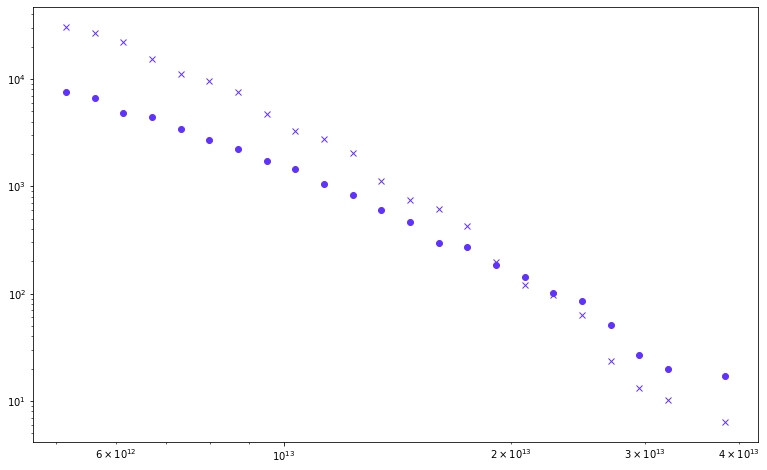

32 27 27 27


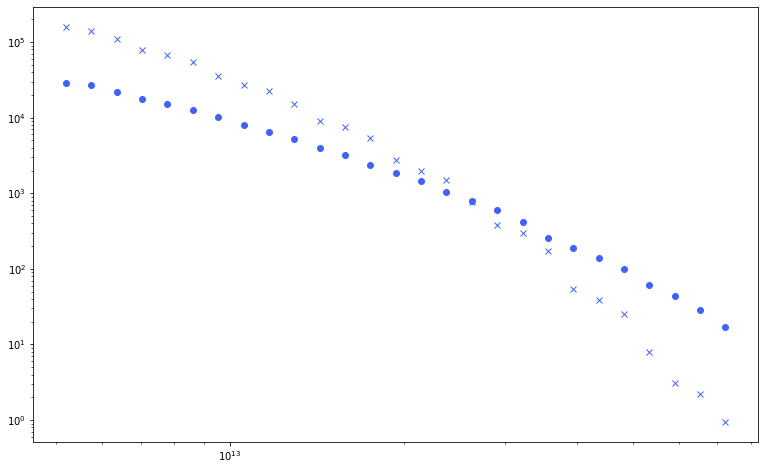

32 28 28 28


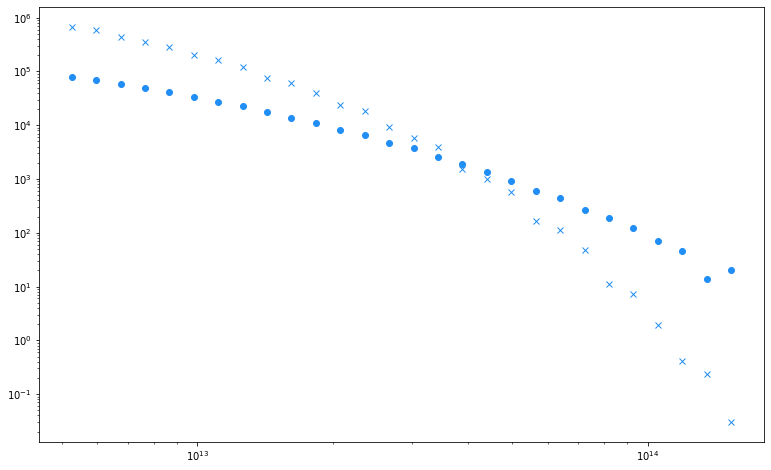

32 28 28 28


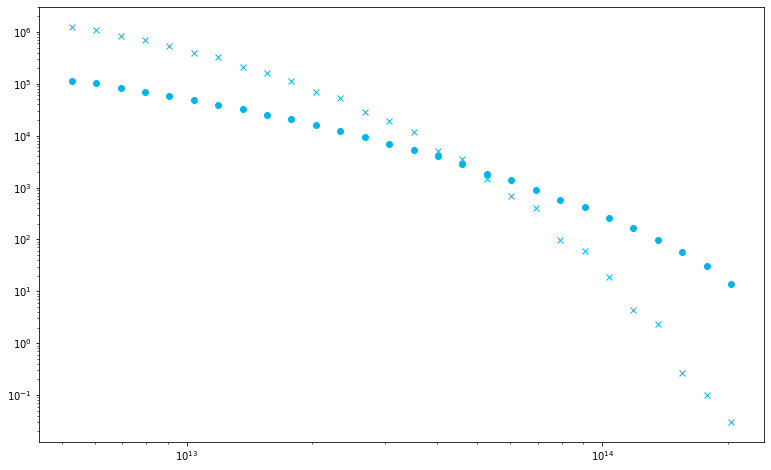

32 28 28 28


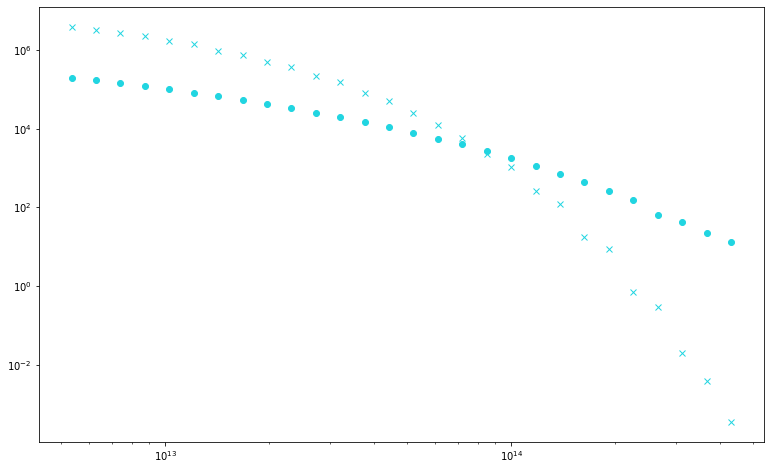

32 28 28 28


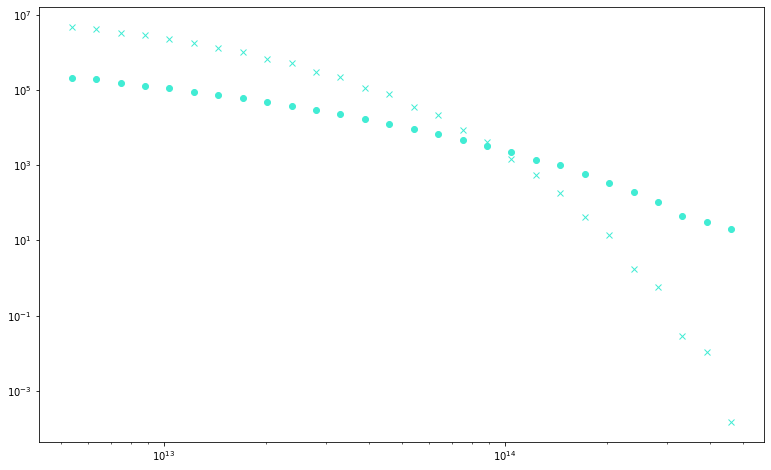

32 28 28 28


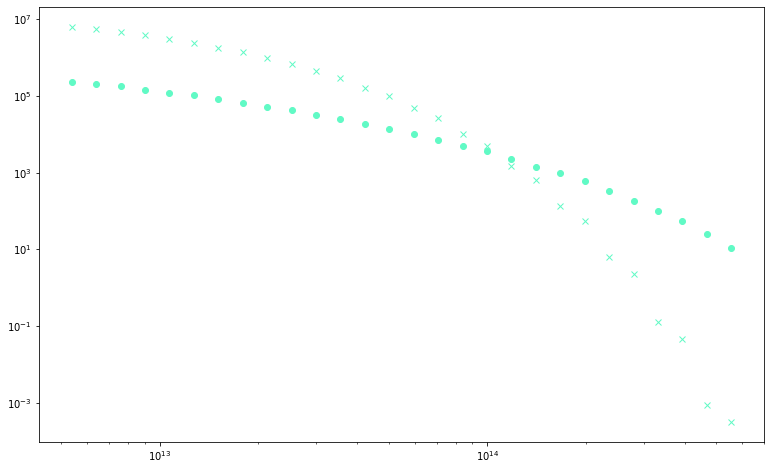

32 28 28 28


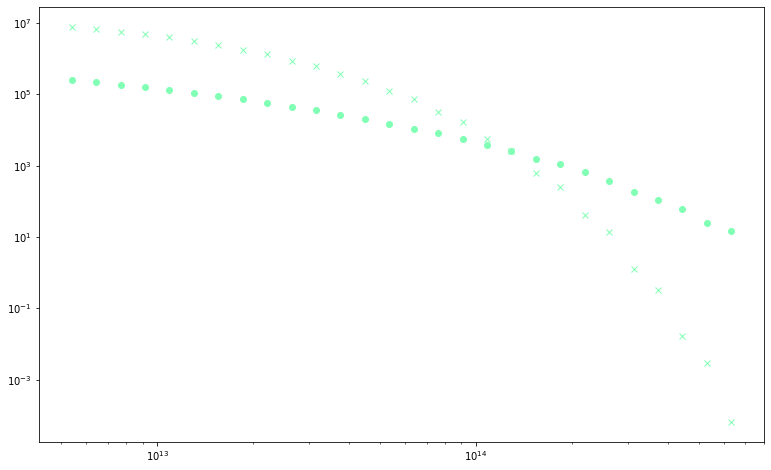

32 28 28 28


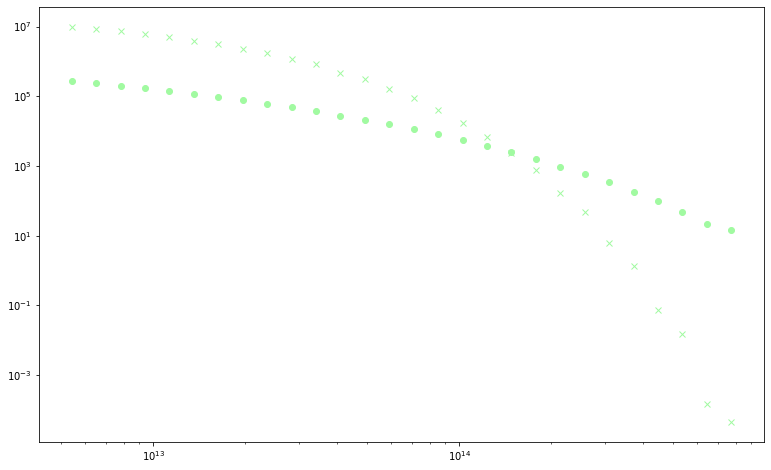

32 27 27 27


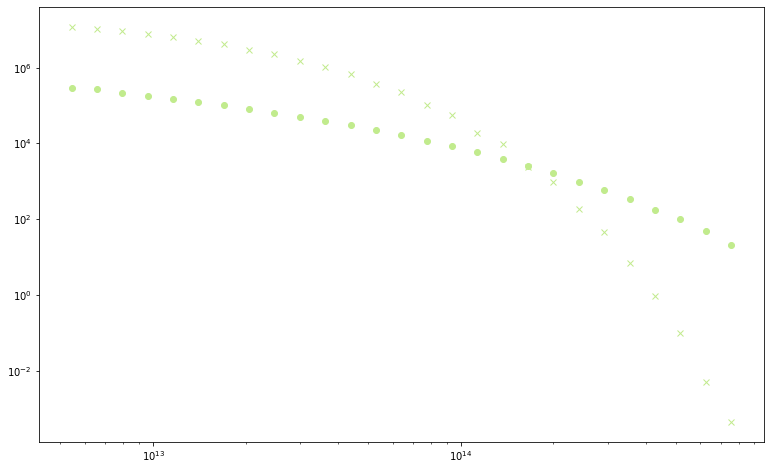

32 27 27 27


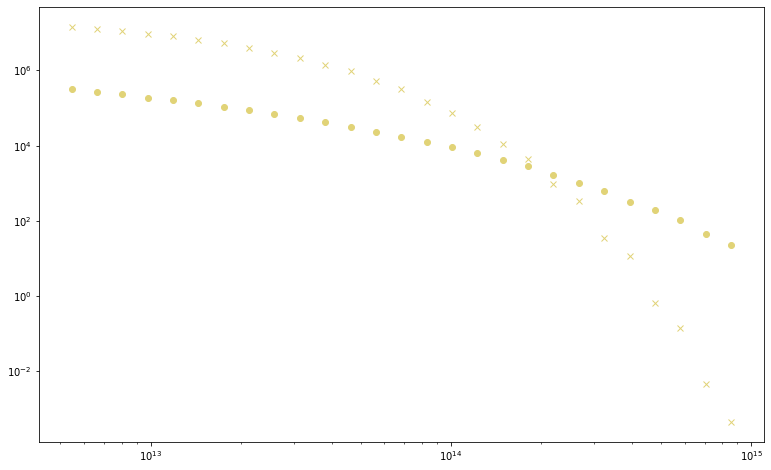

32 28 28 28


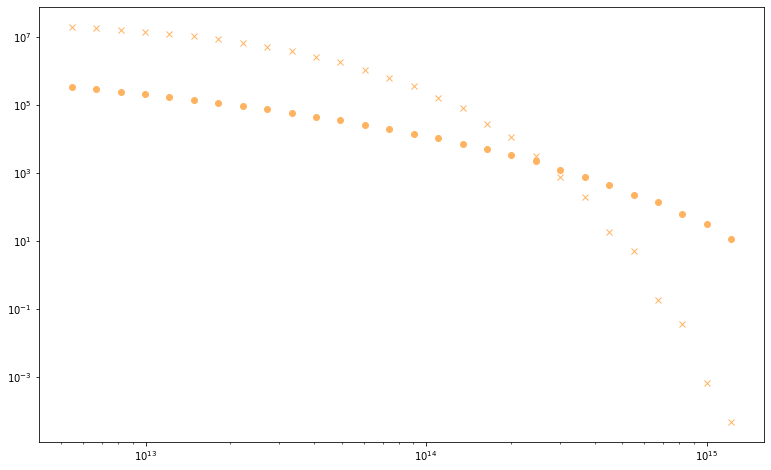

32 27 27 27


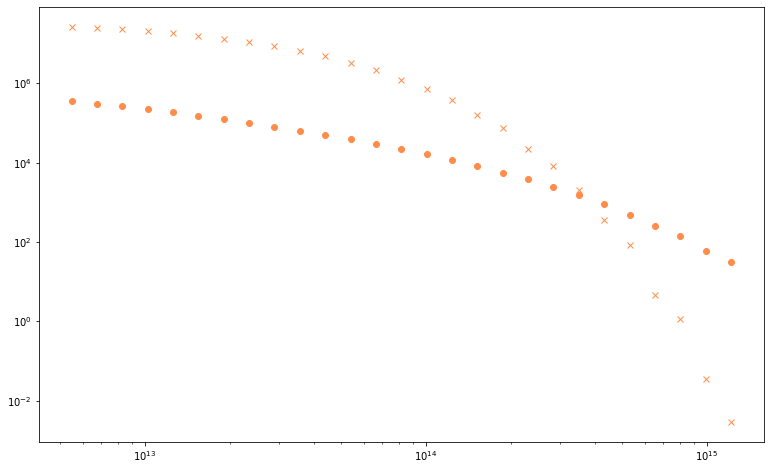

32 28 28 28


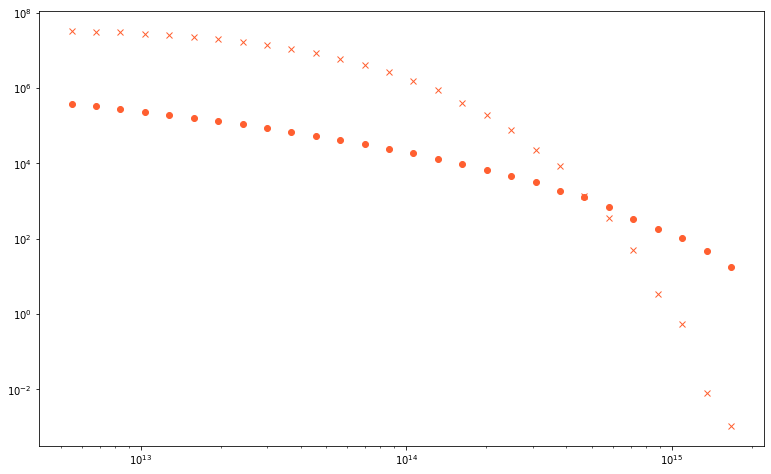

32 28 28 28


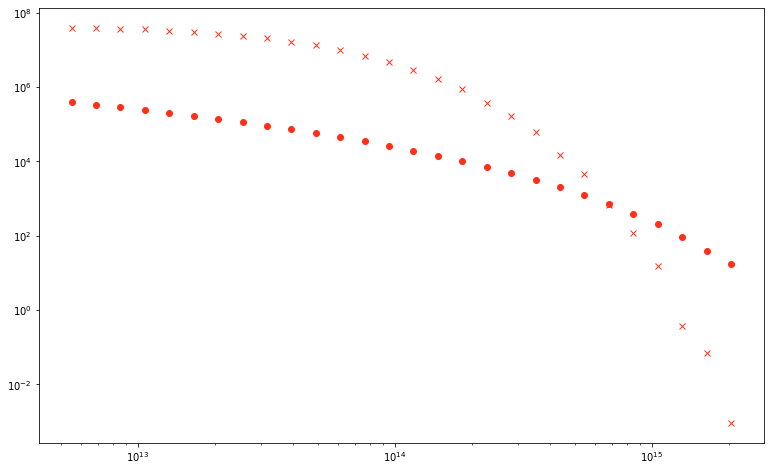

32 28 28 28


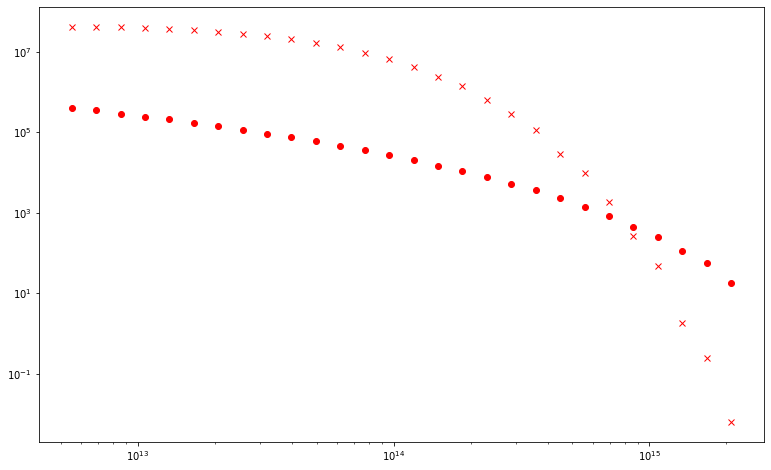

In [31]:

from scipy.interpolate import interp1d
i=0
for (z, a) in zip((Pkz.keys()), (dndMs.keys())):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,8))

    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M']
    N = c_data['N']
    
    vol = c_data['vol']
    
    edges = c_data['bin_edges']
    dM = np.array([edges[i+1]-edges[i] for i in range(len(edges)-1)])
    dlog10M = np.mean(np.diff(np.log10(edges)))
#     print(np.diff(np.log10(edges)))

    Ngt10 = np.where(N>10)
    dndM = (N[Ngt10]/vol)/dM[Ngt10]

#     Ms_tinker = np.logspace(12,17, 50, 10)


    Mpart = NvMs[1]['Mpart']
    vol = data[0]['vol']
    Ms_tinker = np.logspace(np.log10(100*Mpart), 17, 30, 10)
    tinker_eval = [tinker(a, M_c,**MLE_params)*vol for M_c in Ms_tinker]
    f_dndM = interp1d(Ms_tinker, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
    
    edge_pairs = np.array([[edges[i], edges[i+1]] for i in range(len(edges)-1)])
    edge_pairs = edge_pairs[Ngt10]

    
    tinker_eval = np.array([ quad(f_dndM, edge[0],  edge[1])[0] for edge in edge_pairs])

#     for i in range(len(edge_pairs[Ngt10])):
#         plt.scatter(edge_pairs[i], [N[i], N[i]])
#     tinker_eval = np.array([tinker_log10(a, M_c, **MLE_params)*vol*dlog10M for (M_c,dm) in zip(Ms,dM)])

    print(len(edges),len(tinker_eval), len(Ms), len(N))
    color = plt.colormaps["rainbow"]((i+1)/len(Pkz.keys()))[:-1]

    ax.scatter(Ms, N, c=color)
    ax.plot(Ms, tinker_eval, 'x' ,c=color)
    plt.xscale('log')
    plt.yscale('log')
    i+=1
    plt.show()
#     print(len(data))

In [237]:
def log_prob(param_values):    
    for p_nme in param_values:
        p = param_values[p_nme]
        if(p< -50 or p>50):
            return -np.inf

    model_vals = [tinker_log10(c_data['a'], c_data['M'],**param_values)*c_data['vol']*c_data['dlog10M'] 
                  for c_data in data]
    log_probs = poisson.logpmf(N_data, mu=model_vals)
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)

In [238]:
from utils import *

In [239]:
# import cProfile
# cProfile.run('tinker(a=1, M=1e13, d0=4,d1=3,e0=4,e1=.3,f0=2,f1=3,g0=1,g1=.1)')

In [240]:
print(1)

1


In [241]:
import warnings
warnings.filterwarnings("ignore")

In [242]:
nwalkers = 100
ndim = len(param_names)

initialpos = np.array([[result['x']] for _ in range(nwalkers)]) + 1e-2 * np.random.normal(size=(nwalkers, ndim))
# print(initialpos)

In [ ]:
from multiprocessing import Pool

sampler = emcee.EnsembleSampler(
    nwalkers = nwalkers,
    ndim = ndim,
    log_prob_fn = log_likelihood,
#     parameter_names= param_names,
    pool=Pool()
)

initialpos = np.random.uniform(size=(nwalkers, ndim))
sampler.run_mcmc(initialpos, 500, progress=True);

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = sampler.get_chain()
labels = param_names

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
print(
    "Autocorrelation time: {0:.2f} steps".format(
        sampler.get_autocorr_time()[0]
    )
)

In [ ]:
import corner
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=labels)


In [ ]:
params_final = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                   zip(*np.percentile(samples, [16, 50, 84],
                                      axis=0)))

In [ ]:
print(list(params_final))

In [ ]:
params_final = dict(zip(param_names,np.percentile(samples,  50,axis=0)))

In [ ]:
params_final

In [ ]:
#give cosmology, a, M => output

from scipy.interpolate import interp1d

for (z, a) in zip(Pkz.keys(), dndMs.keys()):
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M']
    N = c_data['N']
    
    vol = c_data['vol']
    
    edges = c_data['bin_edges']
    dM = np.array([edges[i+1]-edges[i] for i in range(len(edges)-1)])
    dlog10M = np.mean(np.diff(np.log10(edges)))
#     print(np.diff(np.log10(edges)))

    Ngt10 = np.where(N>10)
    dndM = (N[Ngt10]/vol)/dM[Ngt10]

    Ms_tinker = np.logspace(12,17, 50, 10)
    tinker_eval = [tinker_log10(a, M_c, **params_final)*vol*dlog10M for M_c in Ms]
    print(tinker_eval)
    plt.scatter(Ms, N)
    plt.plot(Ms, tinker_eval)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    print(len(data))